# Momentum

## Import Library

In [75]:
import sys
sys.path.append('../../')

In [76]:

from config.constants import *
from backtesting import Backtest
from util.plot_equity import plot_equity_trades
from util.load_data import load_data
from Momentum import Momentum
from util.Save_result_return import save_to_csv
import matplotlib.pyplot as plt
from config.interations import iterations
import pandas as pd
import seaborn as sns
from tqdm import tqdm



## Get Data

In [77]:
XAUUSD = load_data()

In [78]:
XAUUSD['D1'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5043 entries, 2007-01-01 to 2023-03-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5043 non-null   float64
 1   High    5043 non-null   float64
 2   Low     5043 non-null   float64
 3   Close   5043 non-null   float64
 4   Volume  5043 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 236.4 KB


## Define Strategy

In [79]:
strategy = Momentum

In [80]:
account_size = 20000

In [81]:
iterations = iterations

In [82]:
iterations

[{'in_sample': [datetime.datetime(2007, 1, 1, 0, 0),
   datetime.datetime(2010, 12, 31, 0, 0)],
  'out_of_sample': [datetime.datetime(2011, 1, 1, 0, 0),
   datetime.datetime(2012, 12, 31, 0, 0)]},
 {'in_sample': [datetime.datetime(2008, 1, 1, 0, 0),
   datetime.datetime(2011, 12, 31, 0, 0)],
  'out_of_sample': [datetime.datetime(2012, 1, 1, 0, 0),
   datetime.datetime(2013, 12, 31, 0, 0)]},
 {'in_sample': [datetime.datetime(2009, 1, 1, 0, 0),
   datetime.datetime(2012, 12, 31, 0, 0)],
  'out_of_sample': [datetime.datetime(2013, 1, 1, 0, 0),
   datetime.datetime(2014, 12, 31, 0, 0)]},
 {'in_sample': [datetime.datetime(2010, 1, 1, 0, 0),
   datetime.datetime(2013, 12, 31, 0, 0)],
  'out_of_sample': [datetime.datetime(2014, 1, 1, 0, 0),
   datetime.datetime(2015, 12, 31, 0, 0)]},
 {'in_sample': [datetime.datetime(2011, 1, 1, 0, 0),
   datetime.datetime(2014, 12, 31, 0, 0)],
  'out_of_sample': [datetime.datetime(2015, 1, 1, 0, 0),
   datetime.datetime(2016, 12, 31, 0, 0)]},
 {'in_sample': 

# Walk-Forward Optimization

In [83]:
folder_strategy = 'Momentum'

## TF D1

In [84]:
data = XAUUSD['D1']
TF = 'D1'

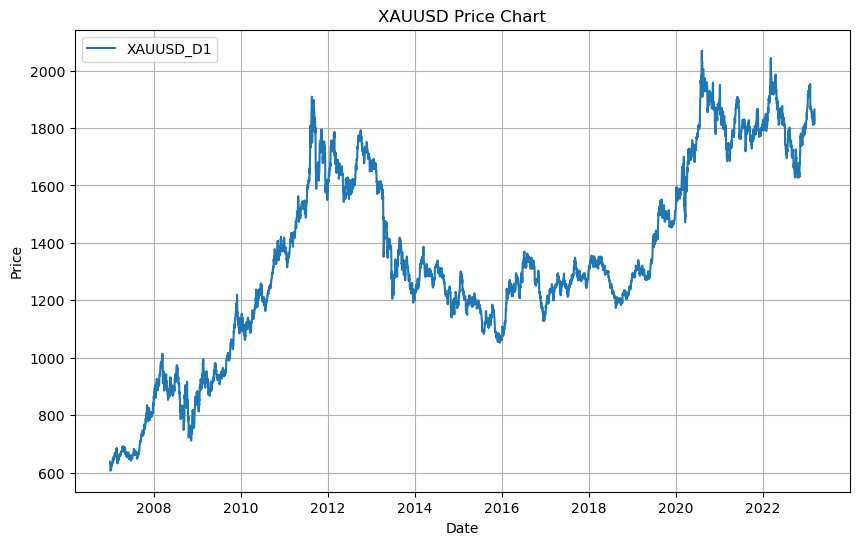

In [85]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='XAUUSD_D1')
plt.title('XAUUSD Price Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Define the Parameters of a Walk-Forward Optimization

In [86]:
def Walk_Forward_Optimization(data, strategy, iterations):

    results_oos = []
    results_is = []
    report = []
    # 1: We iterate over the list of dictionaries
    for iter in tqdm(iterations):

        # 2: We filter the data to only include the relevant dates.
        df_is = data[(data.index >= iter['in_sample'][0])
                     & (data.index <= iter['in_sample'][1])]
        df_oos = data[(data.index >= iter['out_of_sample'][0]) & (
            data.index <= iter['out_of_sample'][1])]

        bt_is = Backtest(df_is, strategy, cash=10_000,
                         commission=0, exclusive_orders=True)

        # 3: Calcualte the optimal parameters using the in-sample data.
        stats_is, heatmap = bt_is.optimize(
            max_dir_count=range(1, 20, 2),
            ATR_SL=range(1, 20, 2),

            maximize='Sharpe Ratio',
            method='grid',
            max_tries=50,
            random_state=0,
            return_heatmap=True)
        results_is.append(stats_is)
        strategy.max_dir_count = stats_is._strategy.max_dir_count
        strategy.ATR_SL = stats_is._strategy.ATR_SL

        # 4: Run the backtest for the out-of-sample data using the optimal parameters.
        bt_oos = Backtest(df_oos, strategy, cash=10_000,
                          commission=0, exclusive_orders=True)
        stats_oos = bt_oos.run()
        results_oos.append(stats_oos)

        # 5: Append relevant metrics to a list of results
        report.append({
            'start_date': stats_oos['Start'],
            'end_date': stats_oos['End'],
            'return': stats_oos['Return [%]'],
            'max_drawdown': stats_oos['Max. Drawdown [%]'],
            'return_ann': stats_oos['Return (Ann.) [%]'],
            'volatility__ann': stats_oos['Volatility (Ann.) [%]'],
            'sharpe_is': stats_is['Sharpe Ratio'],
            'sharpe_ratio': stats_oos['Sharpe Ratio'],
            'Sortino Ratio': stats_oos['Sortino Ratio'],
            'is_heatmap': heatmap,
        })

    return results_is, results_oos, report

In [87]:
results_is_D1, results_oos_D1, report_D1 = Walk_Forward_Optimization(data, strategy,iterations)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  9%|▉         | 1/11 [00:36<06:08, 36.85s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [01:12<05:22, 35.89s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [01:47<04:44, 35.58s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [02:22<04:08, 35.48s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [03:01<03:39, 36.66s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 55%|█████▍    | 6/11 [03:37<03:02, 36.54s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 64%|██████▎   | 7/11 [04:13<02:24, 36.16s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 73%|███████▎  | 8/11 [04:49<01:48, 36.28s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 82%|████████▏ | 9/11 [05:25<01:12, 36.03s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 91%|█████████ | 10/11 [06:03<00:36, 36.73s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 11/11 [06:48<00:00, 37.13s/it]


In [88]:
pd.DataFrame(report_D1)

,start_date,end_date,return,max_drawdown,return_ann,volatility__ann,sharpe_is,sharpe_ratio,Sortino Ratio,is_heatmap
0,2011-01-02,2012-12-31,-0.220075,-5.318711,-0.089077,2.583175,0.478333,0.000000,0.000000,max_dir_count ATR_SL 1 9 ...
1,2012-01-02,2013-12-31,1.450043,-3.230664,0.584021,2.389558,0.429978,0.244406,0.380874,max_dir_count ATR_SL 1 9 ...
2,2013-01-01,2014-12-31,3.967430,-2.053314,1.588806,2.089694,0.110859,0.760306,1.211416,max_dir_count ATR_SL 1 9 ...
3,2014-01-01,2015-12-31,-0.844050,-2.350605,-0.342825,0.767583,0.269232,0.000000,0.000000,max_dir_count ATR_SL 1 9 ...
4,2015-01-01,2016-12-30,0.583029,-1.765560,0.236183,1.374749,0.428107,0.171801,0.258471,max_dir_count ATR_SL 1 9 ...
5,2016-01-03,2017-12-29,0.632096,-1.782377,0.256851,1.260718,0.681939,0.203734,0.297122,max_dir_count ATR_SL 1 9 ...
6,2017-01-02,2018-12-31,-0.092530,-0.103059,-0.037559,0.066062,0.576418,0.000000,0.000000,max_dir_count ATR_SL 1 9 ...
7,2018-01-01,2019-12-31,-0.122602,-0.217882,-0.049530,0.099818,0.910311,0.000000,0.000000,max_dir_count ATR_SL 1 9 ...
8,2019-01-01,2020-12-31,-0.105173,-0.511422,-0.042487,0.535958,0.833668,0.000000,0.000000,max_dir_count ATR_SL 1 9 ...
9,2020-01-01,2021-12-31,-0.730780,-3.778053,-0.296718,2.737674,0.489259,0.000000,0.000000,max_dir_count ATR_SL 1 9 ...


### Plot Heatmap

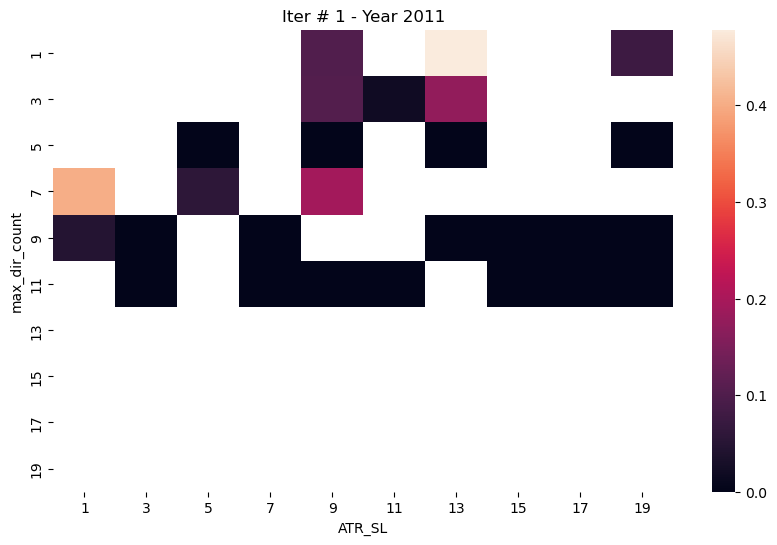

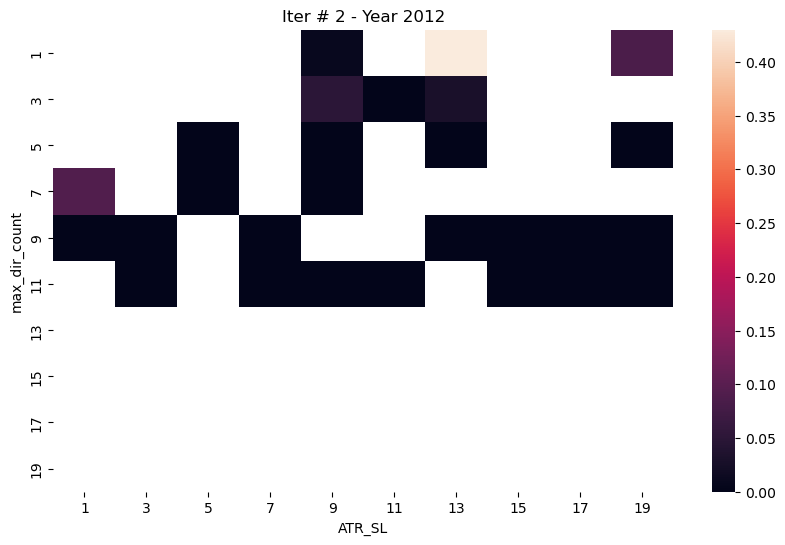

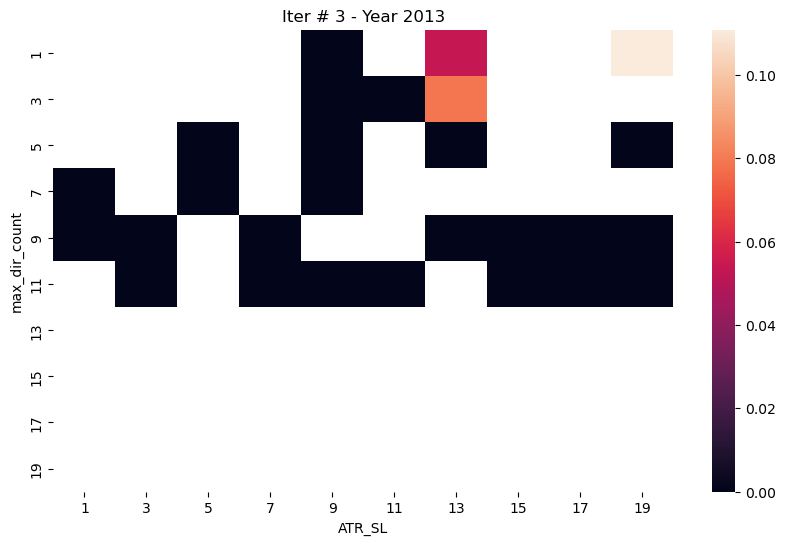

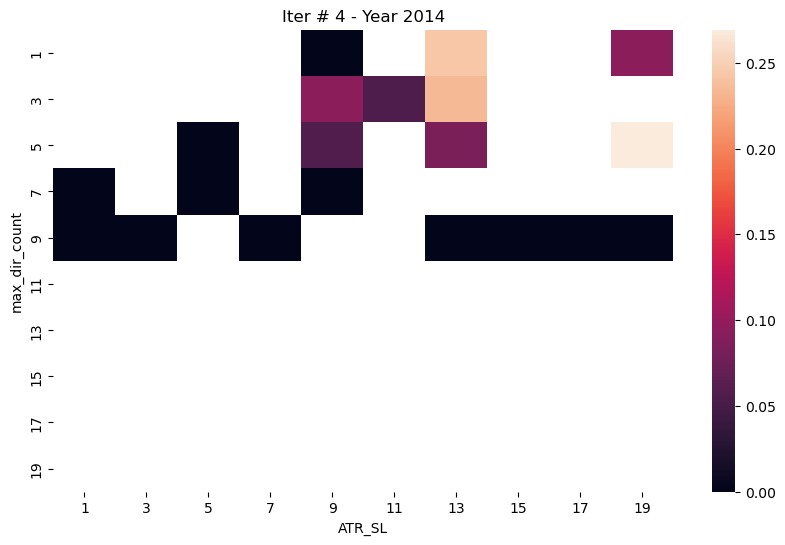

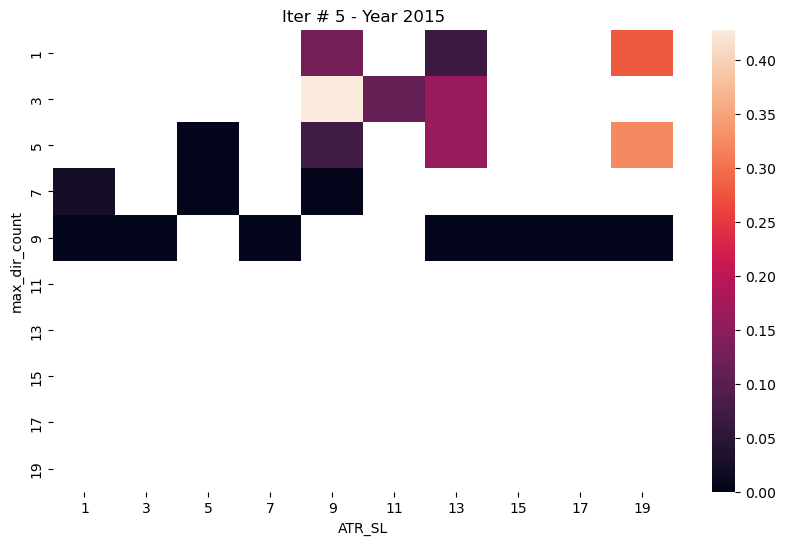

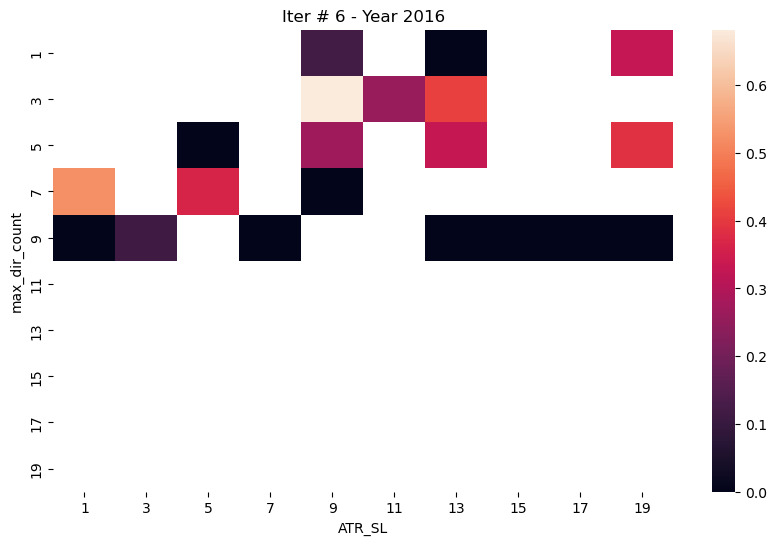

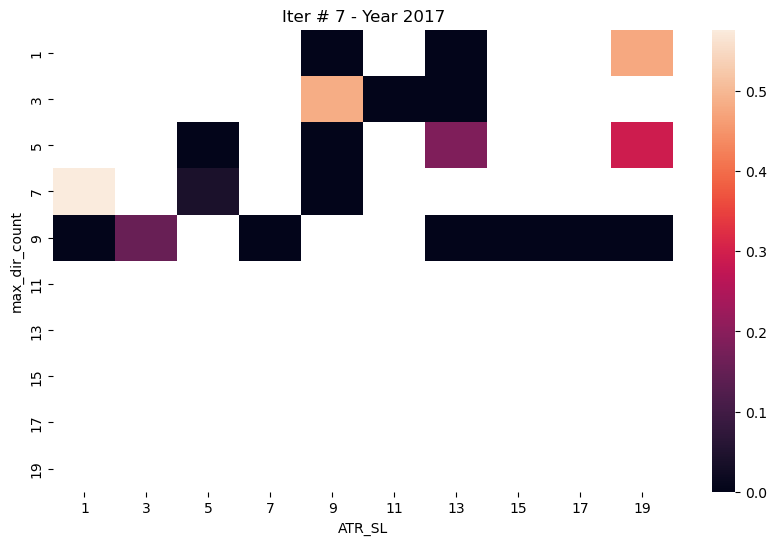

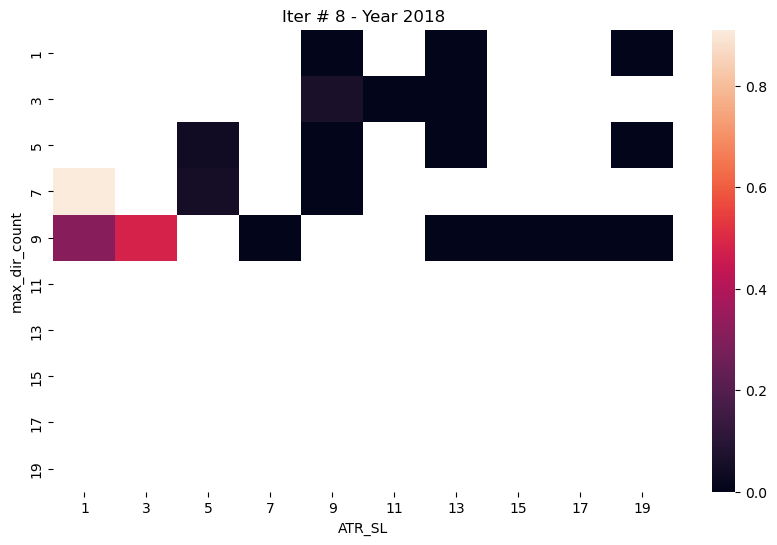

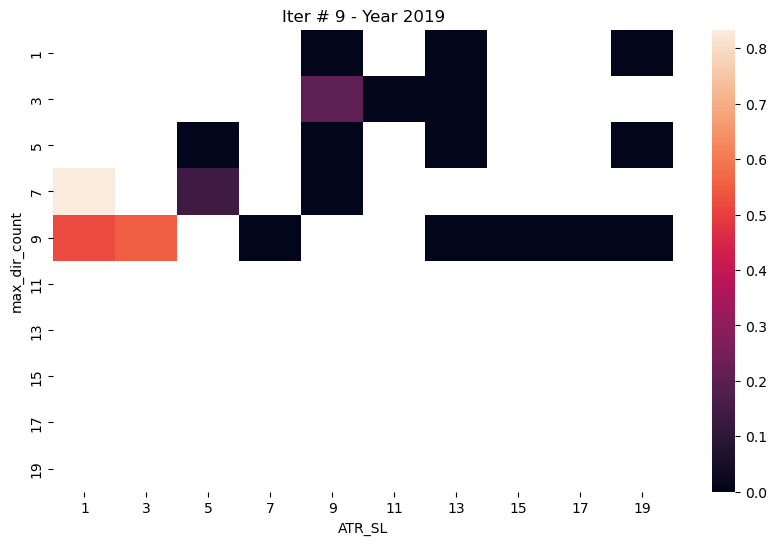

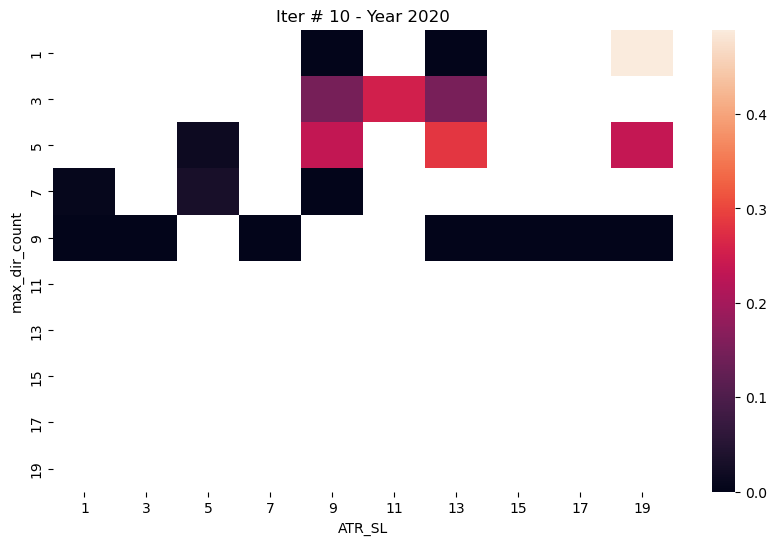

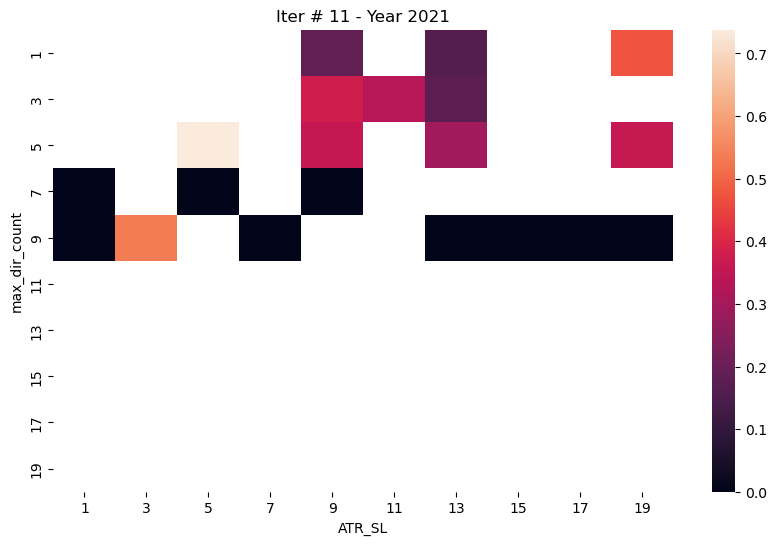

In [89]:
import matplotlib.pyplot as plt

rows = len(report_D1)
for idx, res in enumerate(report_D1):
    plt.figure(figsize=(10, 6))
    plt.plot(idx+1)
    plt.title(f"Iter # {idx+1} - Year {res['start_date'].year}")
    sns.heatmap(res['is_heatmap'].unstack())
    plt.show()

### Save output

In [90]:
for i in range(len(iterations)) :
    save_to_csv(
        results_is_D1[i], f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_is_{i+1}_{TF}.csv')
    
    save_to_csv(
        results_oos_D1[i], f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_oos_{i+1}_{TF}.csv')

In [91]:
results_is_All_D1 = pd.DataFrame()  
for df in results_is_D1:
    results_is_All_D1 = pd.concat(
        [results_is_All_D1, df['_equity_curve']], axis=0, ignore_index=False)
pd.DataFrame(results_is_All_D1)

,Equity,DrawdownPct,DrawdownDuration
Time,,,
2007-01-01,10000.000,0.0,NaT
2007-01-02,10000.000,0.0,NaT
2007-01-03,10000.000,0.0,NaT
2007-01-04,10000.000,0.0,NaT
2007-01-05,10000.000,0.0,NaT
...,...,...,...
2020-12-27,10338.229,0.0,NaT
2020-12-28,10338.229,0.0,NaT
2020-12-29,10338.229,0.0,NaT


In [92]:
results_oos_All_D1 = pd.DataFrame()
for df in results_oos_D1:
    results_oos_All_D1 = pd.concat(
        [results_oos_All_D1, df['_equity_curve']], axis=0, ignore_index=False)
pd.DataFrame(results_oos_All_D1)

,Equity,DrawdownPct,DrawdownDuration
Time,,,
2011-01-02,10000.000,0.000000,NaT
2011-01-03,10000.000,0.000000,NaT
2011-01-04,10000.000,0.000000,NaT
2011-01-05,10000.000,0.000000,NaT
2011-01-06,10000.000,0.000000,NaT
...,...,...,...
2022-12-26,9954.726,0.014175,NaT
2022-12-27,9954.726,0.014175,NaT
2022-12-28,9954.726,0.014175,NaT


In [93]:
results_is_All_D1.to_csv(
    f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_is_All_{TF}.csv', index=True)

In [94]:
results_oos_All_D1.to_csv(
    f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_oos_All_{TF}.csv', index=True)

## TF H4

In [95]:
data = XAUUSD['H4']
TF = 'H4'

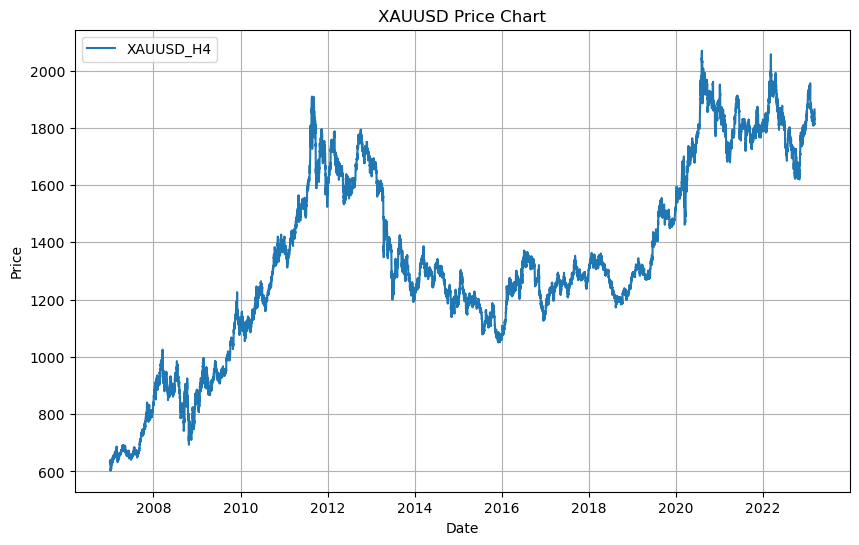

In [96]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label=f'XAUUSD_{TF}')
plt.title('XAUUSD Price Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Define the Parameters of a Walk-Forward Optimization

In [97]:
def Walk_Forward_Optimization(data, strategy, iterations):

    results_oos = []
    results_is = []
    report = []
    # 1: We iterate over the list of dictionaries
    for iter in tqdm(iterations):

        # 2: We filter the data to only include the relevant dates.
        df_is = data[(data.index >= iter['in_sample'][0])
                    & (data.index <= iter['in_sample'][1])]
        df_oos = data[(data.index >= iter['out_of_sample'][0]) & (
            data.index <= iter['out_of_sample'][1])]

        bt_is = Backtest(df_is, strategy, cash=10_000,
                        commission=0, exclusive_orders=True)

        # 3: Calcualte the optimal parameters using the in-sample data.
        stats_is, heatmap = bt_is.optimize(
            max_dir_count=range(1, 20, 2),
            ATR_SL=range(1, 20, 2),

            maximize='Sharpe Ratio',
            method='grid',
            max_tries=50,
            random_state=0,
            return_heatmap=True)
        results_is.append(stats_is)
        strategy.max_dir_count = stats_is._strategy.max_dir_count
        strategy.ATR_SL = stats_is._strategy.ATR_SL

        # 4: Run the backtest for the out-of-sample data using the optimal parameters.
        bt_oos = Backtest(df_oos, strategy, cash=10_000,
                        commission=0, exclusive_orders=True)
        stats_oos = bt_oos.run()
        results_oos.append(stats_oos)

        # 5: Append relevant metrics to a list of results
        report.append({
            'start_date': stats_oos['Start'],
            'end_date': stats_oos['End'],
            'return': stats_oos['Return [%]'],
            'max_drawdown': stats_oos['Max. Drawdown [%]'],
            'return_ann': stats_oos['Return (Ann.) [%]'],
            'volatility__ann': stats_oos['Volatility (Ann.) [%]'],
            'sharpe_is': stats_is['Sharpe Ratio'],
            'sharpe_ratio': stats_oos['Sharpe Ratio'],
            'Sortino Ratio': stats_oos['Sortino Ratio'],
            'is_heatmap': heatmap,
        })

    return results_is, results_oos, report

In [98]:
results_is_H4, results_oos_H4, report_H4 = Walk_Forward_Optimization(data, strategy,iterations)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  9%|▉         | 1/11 [04:25<44:18, 265.82s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [08:49<39:39, 264.40s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [13:47<37:20, 280.07s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [17:49<30:53, 264.75s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [22:28<27:00, 270.15s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 55%|█████▍    | 6/11 [26:55<22:25, 269.05s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 64%|██████▎   | 7/11 [31:54<18:34, 278.62s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 73%|███████▎  | 8/11 [37:17<14:38, 292.91s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 82%|████████▏ | 9/11 [41:14<09:10, 275.26s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 91%|█████████ | 10/11 [44:50<04:17, 257.11s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 11/11 [48:22<00:00, 263.85s/it]


In [99]:
pd.DataFrame(report_H4)

,start_date,end_date,return,max_drawdown,return_ann,volatility__ann,sharpe_is,sharpe_ratio,Sortino Ratio,is_heatmap
0,2011-01-02 20:00:00,2012-12-31 00:00:00,-1.190201,-2.885807,-0.483146,1.727538,1.144135,0.000000,0.000000,max_dir_count ATR_SL 1 9 ...
1,2012-01-02 20:00:00,2013-12-31 00:00:00,1.806209,-2.265308,0.726710,2.294986,0.495559,0.316651,0.499973,max_dir_count ATR_SL 1 9 ...
2,2013-01-01 20:00:00,2014-12-31 00:00:00,-0.566803,-1.991712,-0.230026,1.011479,0.415941,0.000000,0.000000,max_dir_count ATR_SL 1 9 ...
3,2014-01-01 20:00:00,2015-12-31 00:00:00,1.413117,-1.267253,0.570128,1.270497,0.617821,0.448745,0.724261,max_dir_count ATR_SL 1 9 ...
4,2015-01-01 20:00:00,2016-12-30 20:00:00,0.796624,-2.391038,0.322506,1.319516,0.767182,0.244412,0.377969,max_dir_count ATR_SL 1 9 ...
5,2016-01-03 20:00:00,2017-12-29 20:00:00,-1.146274,-2.490689,-0.468253,1.228360,0.612250,0.000000,0.000000,max_dir_count ATR_SL 1 9 ...
6,2017-01-02 20:00:00,2018-12-31 00:00:00,-0.880687,-2.169389,-0.358320,0.932150,0.538660,0.000000,0.000000,max_dir_count ATR_SL 1 9 ...
7,2018-01-01 20:00:00,2019-12-31 00:00:00,0.080341,-2.437953,0.032437,1.323943,0.612455,0.024501,0.036545,max_dir_count ATR_SL 1 9 ...
8,2019-01-01 20:00:00,2020-12-31 00:00:00,1.748096,-3.070655,0.702317,2.487754,0.811790,0.282310,0.432799,max_dir_count ATR_SL 1 9 ...
9,2020-01-01 20:00:00,2021-12-31 00:00:00,-0.102120,-0.102120,-0.041386,0.044057,0.785250,0.000000,0.000000,max_dir_count ATR_SL 1 9 ...


### Plot Heatmap

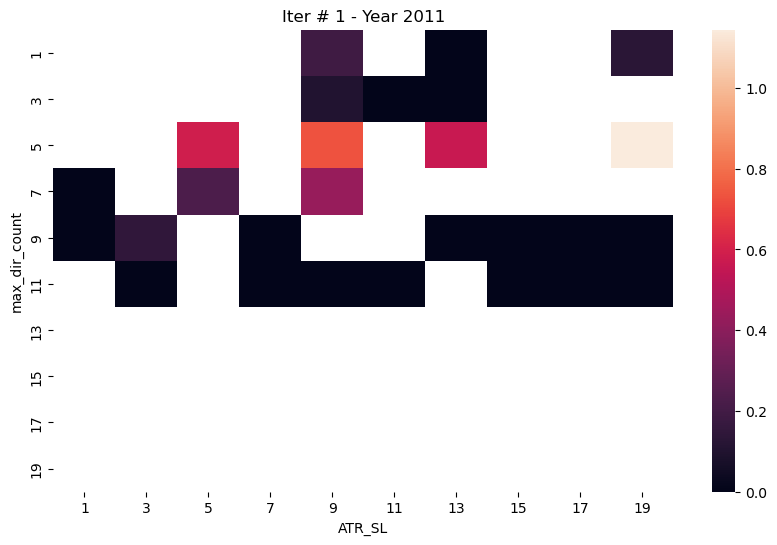

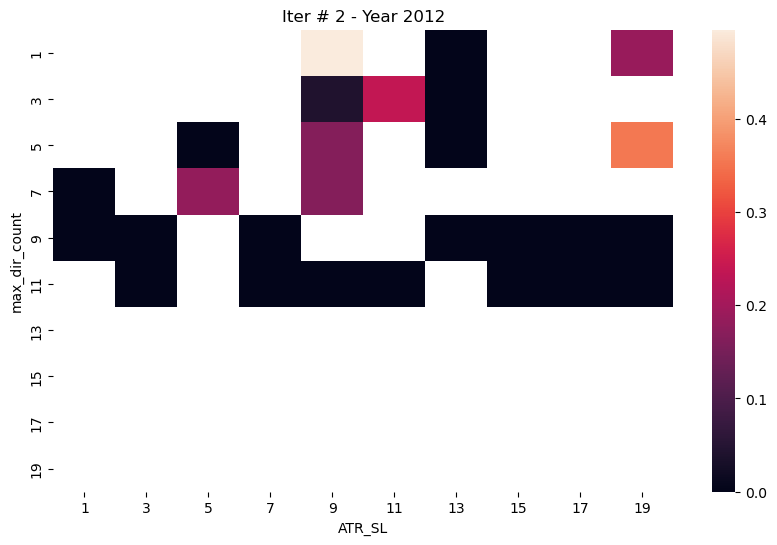

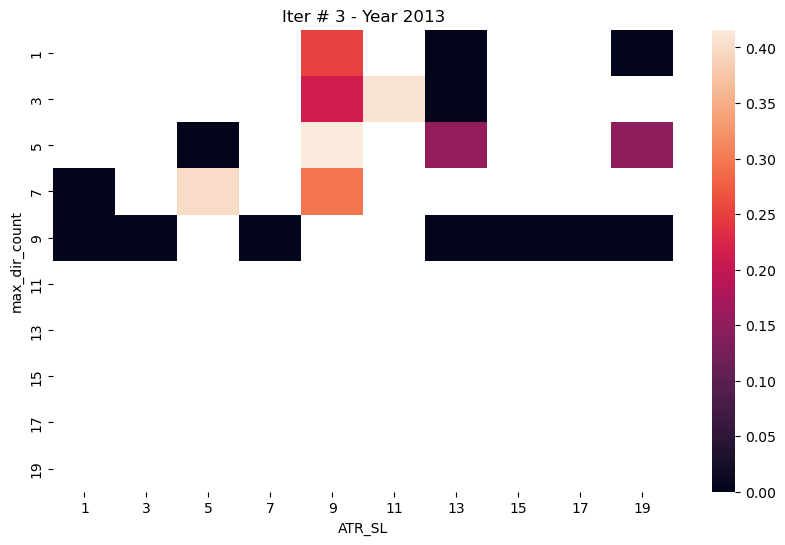

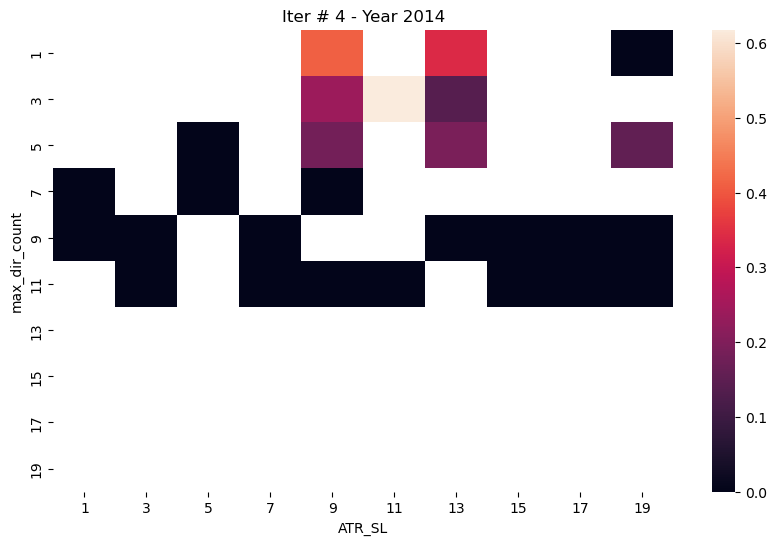

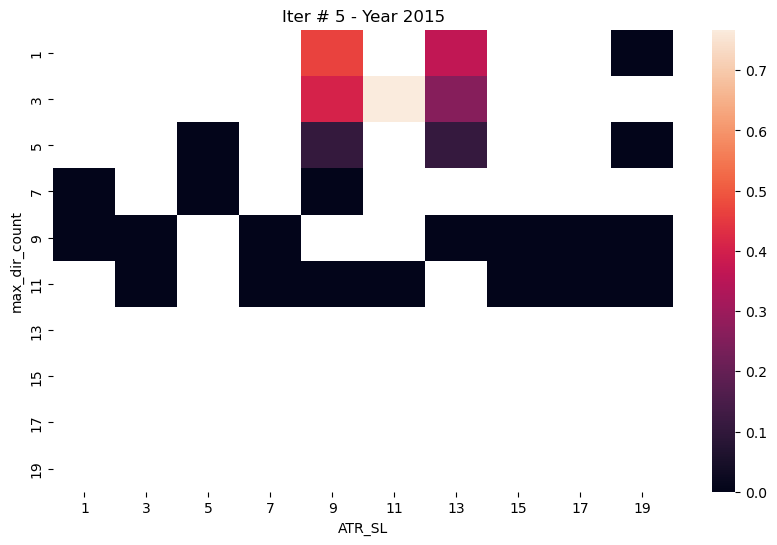

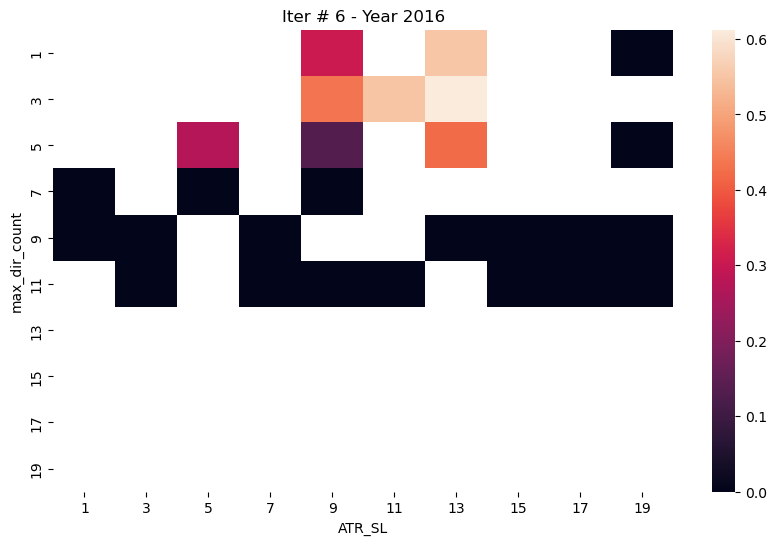

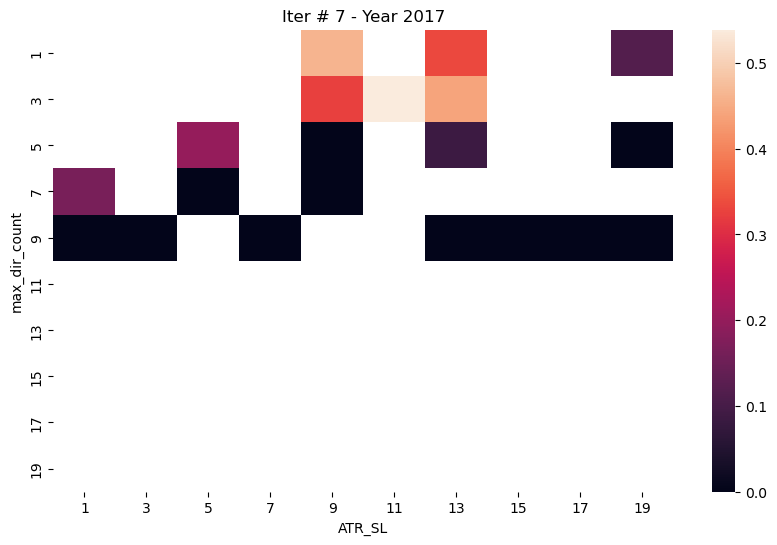

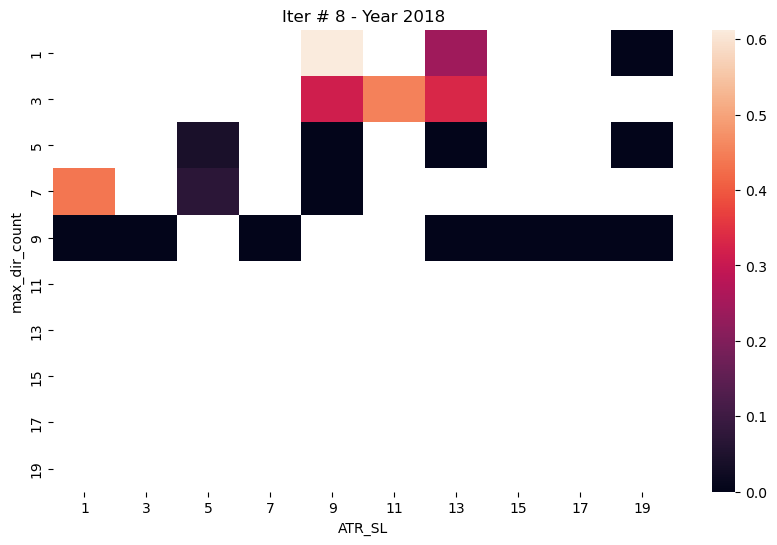

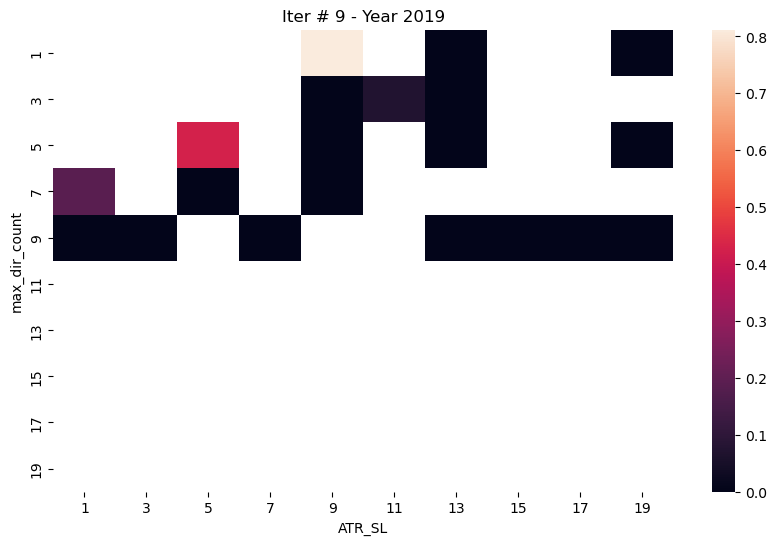

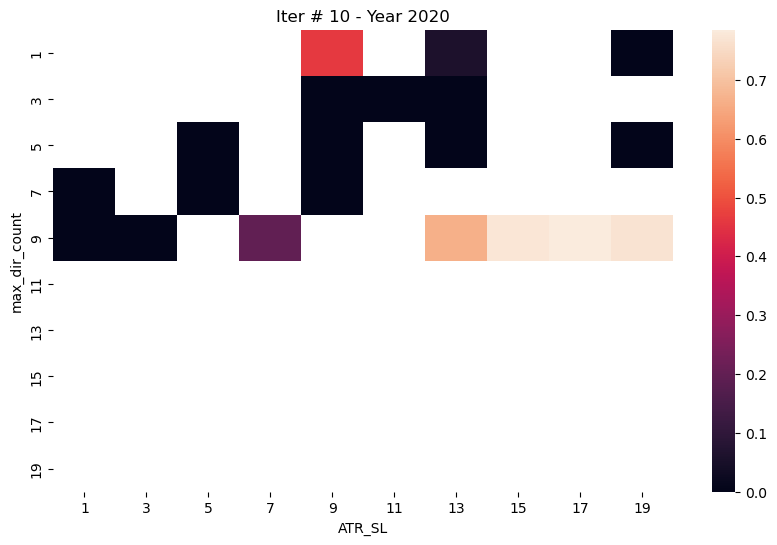

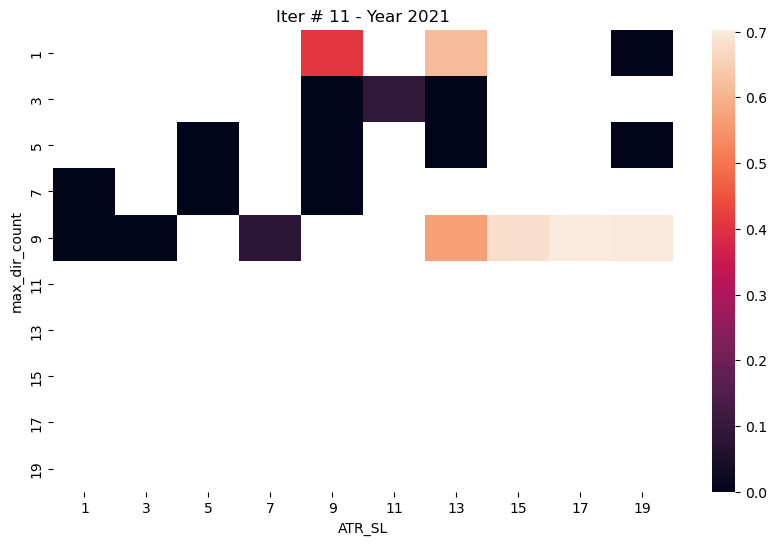

In [100]:
import matplotlib.pyplot as plt

rows = len(report_H4)
for idx, res in enumerate(report_H4):
    plt.figure(figsize=(10, 6))
    plt.plot(idx+1)
    plt.title(f"Iter # {idx+1} - Year {res['start_date'].year}")
    sns.heatmap(res['is_heatmap'].unstack())
    plt.show()

### Save output

In [101]:
for i in range(len(iterations)) :
    save_to_csv(
        results_is_H4[i], f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_is_{i+1}_{TF}.csv')
    
    save_to_csv(
        results_oos_H4[i], f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_oos_{i+1}_{TF}.csv')

In [102]:
results_is_All_H4 = pd.DataFrame()  
for df in results_is_H4:
    results_is_All_H4 = pd.concat(
        [results_is_All_H4, df['_equity_curve']], axis=0, ignore_index=False)
pd.DataFrame(results_is_All_H4)

,Equity,DrawdownPct,DrawdownDuration
Time,,,
2007-01-01 00:00:00,10000.000,0.0000,NaT
2007-01-01 04:00:00,10000.000,0.0000,NaT
2007-01-01 08:00:00,10000.000,0.0000,NaT
2007-01-01 12:00:00,10000.000,0.0000,NaT
2007-01-01 16:00:00,10000.000,0.0000,NaT
...,...,...,...
2020-12-30 08:00:00,10056.673,0.0012,NaT
2020-12-30 12:00:00,10056.673,0.0012,NaT
2020-12-30 16:00:00,10056.673,0.0012,NaT


In [103]:
results_oos_All_H4 = pd.DataFrame()
for df in results_oos_H4:
    results_oos_All_H4 = pd.concat(
        [results_oos_All_H4, df['_equity_curve']], axis=0, ignore_index=False)
pd.DataFrame(results_oos_All_H4)

,Equity,DrawdownPct,DrawdownDuration
Time,,,
2011-01-02 20:00:00,10000.00,0.000000,NaT
2011-01-03 00:00:00,10000.00,0.000000,NaT
2011-01-03 04:00:00,10000.00,0.000000,NaT
2011-01-03 08:00:00,10000.00,0.000000,NaT
2011-01-03 12:00:00,10000.00,0.000000,NaT
...,...,...,...
2022-12-30 04:00:00,9989.43,0.001057,NaT
2022-12-30 08:00:00,9989.43,0.001057,NaT
2022-12-30 12:00:00,9989.43,0.001057,NaT


In [104]:
results_is_All_H4.to_csv(
    f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_is_All_{TF}.csv', index=True)

In [105]:
results_oos_All_H4.to_csv(
    f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_oos_All_{TF}.csv', index=True)

## TF H1

In [106]:
data = XAUUSD['H1']
TF = 'H1'

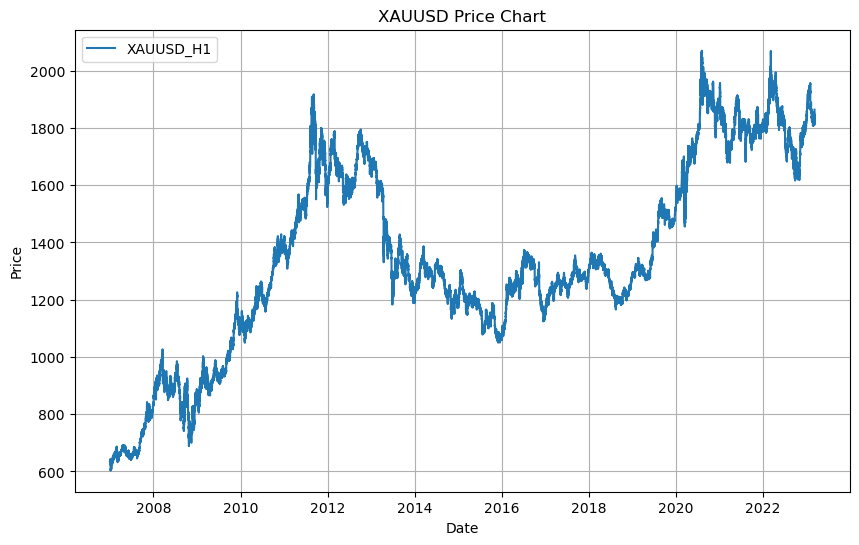

In [107]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label=f'XAUUSD_{TF}')
plt.title('XAUUSD Price Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Define the Parameters of a Walk-Forward Optimization

In [108]:
def Walk_Forward_Optimization(data, strategy, iterations):

    results_oos = []
    results_is = []
    report = []
    # 1: We iterate over the list of dictionaries
    for iter in tqdm(iterations):

        # 2: We filter the data to only include the relevant dates.
        df_is = data[(data.index >= iter['in_sample'][0])
                    & (data.index <= iter['in_sample'][1])]
        df_oos = data[(data.index >= iter['out_of_sample'][0]) & (
            data.index <= iter['out_of_sample'][1])]

        bt_is = Backtest(df_is, strategy, cash=10_000,
                        commission=0, exclusive_orders=True)

        # 3: Calcualte the optimal parameters using the in-sample data.
        stats_is, heatmap = bt_is.optimize(
            max_dir_count=range(1, 20, 2),
            ATR_SL=range(1, 20, 2),

            maximize='Sharpe Ratio',
            method='grid',
            max_tries=50,
            random_state=0,
            return_heatmap=True)
        results_is.append(stats_is)
        strategy.max_dir_count = stats_is._strategy.max_dir_count
        strategy.ATR_SL = stats_is._strategy.ATR_SL

        # 4: Run the backtest for the out-of-sample data using the optimal parameters.
        bt_oos = Backtest(df_oos, strategy, cash=10_000,
                        commission=0, exclusive_orders=True)
        stats_oos = bt_oos.run()
        results_oos.append(stats_oos)

        # 5: Append relevant metrics to a list of results
        report.append({
            'start_date': stats_oos['Start'],
            'end_date': stats_oos['End'],
            'return': stats_oos['Return [%]'],
            'max_drawdown': stats_oos['Max. Drawdown [%]'],
            'return_ann': stats_oos['Return (Ann.) [%]'],
            'volatility__ann': stats_oos['Volatility (Ann.) [%]'],
            'sharpe_is': stats_is['Sharpe Ratio'],
            'sharpe_ratio': stats_oos['Sharpe Ratio'],
            'Sortino Ratio': stats_oos['Sortino Ratio'],
            'is_heatmap': heatmap,
        })

    return results_is, results_oos, report

In [109]:
results_is_H1, results_oos_H1, report_H1 = Walk_Forward_Optimization(data, strategy,iterations)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
  9%|▉         | 1/11 [24:40<4:06:49, 1480.96s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [57:08<4:23:19, 1755.47s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [1:36:35<4:31:18, 2034.80s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [2:19:57<4:23:29, 2258.57s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [2:57:55<5:11:22, 2668.94s/it]


KeyboardInterrupt: 

In [ ]:
pd.DataFrame(report_H1)

### Plot Heatmap

In [ ]:
import matplotlib.pyplot as plt

rows = len(report_H1)
for idx, res in enumerate(report_H1):
    plt.figure(figsize=(10, 6))
    plt.plot(idx+1)
    plt.title(f"Iter # {idx+1} - Year {res['start_date'].year}")
    sns.heatmap(res['is_heatmap'].unstack())
    plt.show()

### Save output

In [ ]:
for i in range(len(iterations)) :
    save_to_csv(
        results_is_H1[i], f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_is_{i+1}_{TF}.csv')
    
    save_to_csv(
        results_oos_H1[i], f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_oos_{i+1}_{TF}.csv')

In [ ]:
results_is_All_H1 = pd.DataFrame()  
for df in results_is_H1:
    results_is_All_H1 = pd.concat(
        [results_is_All_H1, df['_equity_curve']], axis=0, ignore_index=False)
pd.DataFrame(results_is_All_H1)

In [ ]:
results_oos_All_H1 = pd.DataFrame()
for df in results_oos_H1:
    results_oos_All_H1 = pd.concat(
        [results_oos_All_H1, df['_equity_curve']], axis=0, ignore_index=False)
pd.DataFrame(results_oos_All_H1)

In [ ]:
results_is_All_H1.to_csv(
    f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_is_All_{TF}.csv', index=True)

In [ ]:
results_oos_All_H1.to_csv(
    f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_oos_All_{TF}.csv', index=True)

## TF M30

In [ ]:
data = XAUUSD['M30']
TF = 'M30'

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label=f'XAUUSD_{TF}')
plt.title('XAUUSD Price Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Define the Parameters of a Walk-Forward Optimization

In [ ]:
def Walk_Forward_Optimization(data, strategy, iterations):

    results_oos = []
    results_is = []
    report = []
    # 1: We iterate over the list of dictionaries
    for iter in tqdm(iterations):

        # 2: We filter the data to only include the relevant dates.
        df_is = data[(data.index >= iter['in_sample'][0])
                    & (data.index <= iter['in_sample'][1])]
        df_oos = data[(data.index >= iter['out_of_sample'][0]) & (
            data.index <= iter['out_of_sample'][1])]

        bt_is = Backtest(df_is, strategy, cash=10_000,
                        commission=0, exclusive_orders=True)

        # 3: Calcualte the optimal parameters using the in-sample data.
        stats_is, heatmap = bt_is.optimize(
            max_dir_count=range(1, 10, 2),
            ATR_SL=range(1, 10, 2),

            maximize='Sharpe Ratio',
            method='grid',
            max_tries=50,
            random_state=0,
            return_heatmap=True)
        results_is.append(stats_is)
        strategy.max_dir_count = stats_is._strategy.max_dir_count
        strategy.ATR_SL = stats_is._strategy.ATR_SL

        # 4: Run the backtest for the out-of-sample data using the optimal parameters.
        bt_oos = Backtest(df_oos, strategy, cash=10_000,
                        commission=0, exclusive_orders=True)
        stats_oos = bt_oos.run()
        results_oos.append(stats_oos)

        # 5: Append relevant metrics to a list of results
        report.append({
            'start_date': stats_oos['Start'],
            'end_date': stats_oos['End'],
            'return': stats_oos['Return [%]'],
            'max_drawdown': stats_oos['Max. Drawdown [%]'],
            'return_ann': stats_oos['Return (Ann.) [%]'],
            'volatility__ann': stats_oos['Volatility (Ann.) [%]'],
            'sharpe_is': stats_is['Sharpe Ratio'],
            'sharpe_ratio': stats_oos['Sharpe Ratio'],
            'Sortino Ratio': stats_oos['Sortino Ratio'],
            'is_heatmap': heatmap,
        })

    return results_is, results_oos, report

In [ ]:
results_is_M30, results_oos_M30, report_M30 = Walk_Forward_Optimization(data, strategy,iterations)

In [ ]:
pd.DataFrame(report_M30)

### Plot Heatmap

In [ ]:
import matplotlib.pyplot as plt

rows = len(report_M30)
for idx, res in enumerate(report_M30):
    plt.figure(figsize=(10, 6))
    plt.plot(idx+1)
    plt.title(f"Iter # {idx+1} - Year {res['start_date'].year}")
    sns.heatmap(res['is_heatmap'].unstack())
    plt.show()

### Save output

In [ ]:
for i in range(len(iterations)) :
    save_to_csv(
        results_is_M30[i], f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_is_{i+1}_{TF}.csv')
    
    save_to_csv(
        results_oos_M30[i], f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_oos_{i+1}_{TF}.csv')

In [ ]:
results_is_All_M30 = pd.DataFrame()  
for df in results_is_M30:
    results_is_All_M30 = pd.concat(
        [results_is_All_M30, df['_equity_curve']], axis=0, ignore_index=False)
pd.DataFrame(results_is_All_M30)

In [ ]:
results_oos_All_M30 = pd.DataFrame()
for df in results_oos_M30:
    results_oos_All_M30 = pd.concat(
        [results_oos_All_M30, df['_equity_curve']], axis=0, ignore_index=False)
pd.DataFrame(results_oos_All_M30)

In [ ]:
results_is_All_M30.to_csv(
    f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_is_All_{TF}.csv', index=True)

In [ ]:
results_oos_All_M30.to_csv(
    f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_oos_All_{TF}.csv', index=True)